
# CURO Controls Crash Course

---

$\:$ This guide is dedicated to examining the mathematical models and algorithms used by the CU Robotics Club locomotion squad. It is meant for prospective members to learn the backend of what our ideal design process looks like.

> The club's goal is to compete in [Robomaster NA](https://www.robomasterna.com/) against other universities \
> Attempting to get a competitive edge, the team has decided not to share the entirety of the controls stack \
> Don't expect to drop this code in a robot and have a high performance system 

$\:$ The algorithms highlighted here are a demonstration of a mathematical machine the team uses to iterate on and analyze control system designs. 

How to get the most from this Guide
- Ask lots of questions
- Find edge cases and breaking conditions
- Share your thoughts on what is hard/easy to follow
- Suggest improvements through a pull request
- Compare your results with others
- Take your time understanding the methods (maybe even ask a professor)
- Dont be afriad to skip to the sim and play around

In [4]:
#         Import some of ourfavorite packages
#  This must be run but there isn't much to learn from it
import cv2
import time
import imageio
import numpy as np
import scipy.linalg as la
import ipywidgets as widgets
import matplotlib.pyplot as plt

from IPython import display
%matplotlib inline

Python 3.11.2


In [2]:
# Define some Constants for later
# These are scattered throughout the notebook
# so make sure you define them by running this cell
PI = 3.141592653589793
TWO_PI = 2 * PI
HALF_PI = PI / 2
TRI_PI = PI / 3
Q_PI = HALF_PI / 2

## X Drive Chassis Modeling and Dynamics

CURO has selected the X-Drive chassis configuration for all of the robots. This configuration uses 4 Omni-wheels oriented along the X and Y axis. This chassis type has significant benefits compared to the more traditional tank drive, which uses mechanum wheels.

![drive_comparison](chassis_types.jpg)

### Reference Frames

![Frames](reference_frames.jpg)
Start by defining the coordinate systems (reference frame) needed for the definitions in this problem.

$\bar{W}=
\begin{bmatrix}
    1 & 0 & 0 \\ 
    0 & 1 & 0 \\ 
    0 & 0 & 1 \\  
\end{bmatrix}=\begin{bmatrix}
    \hat{x}_w & \hat{y}_w & \hat{z}_w 
\end{bmatrix}^T$ 

> ### $\bar{W}$ Inertial frame (world coordinate system)
> - Does not change position or orientation
> - Z opposite of gravity (we're roboticists not aerospace engineers)
> - X, Y directions can be same as the robot frame on startup

$\bar{R}=
\begin{bmatrix}
    cos(\theta) & -sin(\theta) & 0 \\ 
    sin(\theta) & cos(\theta) & 0 \\ 
    0 & 0 & 1 \\  
\end{bmatrix} =\begin{bmatrix}
    \hat{x}_r & \hat{y}_r & \hat{z}_r 
\end{bmatrix}^T$

> ### $\bar{R}$ Robot frame (chassis coordinate system)
> - Relates the chassis to the world using:
> - - translation in X, Y
> - - rotation about Z
> - Z is parallel to the world frame
> - Wheel 1 & 3 along X axis
> - Wheel 2 & 4 along Y axis

$\bar{G}=
\begin{bmatrix}
    cos(\psi_g) & -sin(\psi_g) & 0 \\ 
    sin(\psi_g) & cos(\psi_g) & 0 \\ 
    0 & 0 & 1 \\  
\end{bmatrix}
\begin{bmatrix}
    cos(\psi_g) & 0 & -sin(\psi_g) \\ 
    0 & 1 & 0 \\  
    sin(\psi_g) & 0 & cos(\psi_g) \\ 
\end{bmatrix}$

> ### $\bar{G}$ Gimbal frame (shooter coordinate system)
> - Relates the shooter to the chassis using:
> - - static translation
> - - rotation about Z and Y
> - Shoots along X axis
> - Need to relate this to the chassis frame to understand it in the world frame

$\:$ The dynamics of the chassis involve four motors and six states. The states represent each degree of freedom and its derivative.

> positional states $[x_w, y_w, \theta_w]$ \
> derivative states $[\dot{x}_w, \dot{y}_w, \dot{\theta}_w]$

*w subscript denotes the value is defined in the world frame*

Starting with a very basic linear state space definition of the chassis

$$\dot{x}=A_{chassis}x_w + B_{chassis}a$$

$$\dot{x} =
\begin{bmatrix}
    0 & 0 & 0 & 1 & 0 & 0 \\ 
    0 & 0 & 0 & 0 & 1 & 0 \\ 
    0 & 0 & 0 & 0 & 0 & 1 \\ 
    0 & 0 & 0 & 0 & 0 & 0 \\ 
    0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}x_w +
\begin{bmatrix}
    0 & 0 & 0 & 0 \\ 
    0 & 0 & 0 & 0 \\ 
    0 & 0 & 0 & 0 \\ 
    1 & 0 & -1 & 0 \\ 
    0 & 1 & 0 & -1 \\
    1 & 1 & 1 & 1  
\end{bmatrix}a
$$

> $a$ is each motors acceleration about it's own axis \
> $x$ is the state of the chassis \
> $\dot{x}$ is the derivative of the state \
> $B_{chassis}$ is derrived from the kinematics of the robot \
> $B_{chassis}a$ contains acceleration of the robot in the robot frame

$$\ddot{x} = a_1 - a_3$$
$$\ddot{y} = a_2 - a_4$$
$$\ddot{\theta} = a_1 + a_2 + a_3 + a_4$$

$$
\begin{bmatrix}
    \ddot{x} \\
    \ddot{y} \\
    \ddot{\theta}
\end{bmatrix}  = 
\begin{bmatrix}
  a_1 - a_3 \\
  a_2 - a_4 \\
  a_1 + a_2 + a_3 + a_4
\end{bmatrix} = \begin{bmatrix}
    1 & 0 & -1 & 0 \\ 
    0 & 1 & 0 & -1 \\
    1 & 1 & 1 & 1  
\end{bmatrix}a$$

Since the states are defined in the world frame to add the robot accelerations they must also be defined in the world frame. Multiply $B_{chassis}a$ by a rotating transformation defined by $\theta$ ($x(3)$ or Z rotation of the robot)

$$R_{RW}=
\begin{bmatrix}
    I & 0 \\
    0 & \bar{R} \\
\end{bmatrix} =
\begin{bmatrix}
    1 & 0 & 0 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 & 0 & 0 \\
    0 & 0 & 0 & cos(\theta) & -sin(\theta) & 0 \\
    0 & 0 & 0 & sin(\theta) & cos(\theta) & 0 \\
    0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}$$

Leading to

$$x=A_{chassis}x_w + R_{RW}B_{chassis}a$$

Now we can use a generic equation for a dc motor

$$J\ddot{\theta}+b\dot{\theta}=Ki$$

Which gives an equation for the acceleration of each motor based on input i, the current.

$$\ddot{\theta}=\frac{-b}{J}\dot{\theta}+\frac{K}{J}i$$

This leads to another state space model

$$\begin{bmatrix}
    \dot{\theta}_{motor} \\
    \ddot{\theta}_{motor}
\end{bmatrix} =
\begin{bmatrix}
    0 & 1 \\
    0 & -\frac{b}{J}
\end{bmatrix}
\begin{bmatrix}
    \theta_{motor} \\
    \dot{\theta}_{motor}
\end{bmatrix}+
\begin{bmatrix}
    0 \\
    \frac{K}{J}
\end{bmatrix}i$$

The final model of our chassis looks like

$$\dot{x} =
\begin{bmatrix}
    0 & 0 & 0 & 1 & 0 & 0 \\ 
    0 & 0 & 0 & 0 & 1 & 0 \\ 
    0 & 0 & 0 & 0 & 0 & 1 \\ 
    0 & 0 & 0 & 0 & 0 & 0 \\ 
    0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}x_w +
\begin{bmatrix}
    1 & 0 & 0 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 & 0 & 0 \\
    0 & 0 & 0 & cos(\theta) & -sin(\theta) & 0 \\
    0 & 0 & 0 & sin(\theta) & cos(\theta) & 0 \\
    0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
    0 & 0 & 0 & 0 \\ 
    0 & 0 & 0 & 0 \\ 
    0 & 0 & 0 & 0 \\ 
    0 & 1 & 0 & -1 \\
    1 & 0 & -1 & 0 \\ 
    1 & 1 & 1 & 1  
\end{bmatrix}a
$$

$$\dot{x} =
\begin{bmatrix}
    0 & 0 & 0 & 1 & 0 & 0 \\ 
    0 & 0 & 0 & 0 & 1 & 0 \\ 
    0 & 0 & 0 & 0 & 0 & 1 \\ 
    0 & 0 & 0 & 0 & 0 & 0 \\ 
    0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}x_w +
\begin{bmatrix}
    0 & 0 & 0 & 0 \\ 
    0 & 0 & 0 & 0 \\ 
    0 & 0 & 0 & 0 \\ 
    -sin(\theta) & cos(\theta) & sin(\theta) & -cos(\theta) \\
    cos(\theta) & sin(\theta) & -cos(\theta) & -sin(\theta) \\ 
    1 & 1 & 1 & 1  
\end{bmatrix}a
$$

With a motor model connecting each input to each motors acceleration
$$\begin{bmatrix}
    \dot{\theta}_{motor} \\
    \ddot{\theta}_{motor}
\end{bmatrix} =
\begin{bmatrix}
    0 & 1 \\
    0 & -\frac{b}{J}
\end{bmatrix}
\begin{bmatrix}
    \theta_{motor} \\
    \dot{\theta}_{motor}
\end{bmatrix}+
\begin{bmatrix}
    0 \\
    \frac{K}{J}
\end{bmatrix}i$$

A discretized version

$$\begin{bmatrix}
    \theta_{motor} (t+1)\\
    \dot{\theta}_{motor} (t+1)
\end{bmatrix} =
\begin{bmatrix}
    0 & 1e^{-3} - 1 \\
    0 & -1e^{-3}\frac{b}{J} - 1
\end{bmatrix}
\begin{bmatrix}
    \theta_{motor} (t)\\
    \dot{\theta}_{motor} (t)
\end{bmatrix}+
\begin{bmatrix}
    0 \\
    \frac{Kt}{J}
\end{bmatrix}i$$

In [46]:
# All time definitions
# These are just more constants, make sure not to change
# any throughout the notebook so they can be reused

# Assume each motor is identical and has the params
b = 0.5
J = 0.25
K = 1

# state space model params
N_CHASSIS_STATES = 6
N_CHASSIS_MOTORS = 4
N_MOTOR_STATES = 2

A_CHASSIS_SHAPE = (N_CHASSIS_STATES, N_CHASSIS_STATES)
B_CHASSIS_SHAPE = (N_CHASSIS_STATES, N_CHASSIS_MOTORS)
A_MOTOR_SHAPE = (N_MOTOR_STATES, N_MOTOR_STATES)
B_MOTOR_SHAPE = (N_MOTOR_STATES,)

# Define A and B matrices for chassis and motor
A_chassis = np.array([[0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 1],
                      [0, 0, 0, 0, 0, 0], # add some simulated gear friction
                      [0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0]]).reshape(A_CHASSIS_SHAPE)

B_chassis = np.array([[0, 0, 0, 0], 
                      [0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 1, 0,-1],
                      [1, 0,-1, 0],
                      [1, 1, 1, 1]]).reshape(B_CHASSIS_SHAPE)

A_motor = np.array([[0, 1],
                    [0, -(b/J)]]).reshape(A_MOTOR_SHAPE)

B_motor = np.array([[0], [K/J]]).reshape(B_MOTOR_SHAPE)

In [47]:
# This cell contains the implementation of 
# our system, not much going on aside from some 
# matrix multiplications.
def motor_dynamics(states, inputs):
    """
    motor dynamics
        inputs:
            states: motor states at t-1 [[θ1, θ1_dot], [θ2, θ2_dot], [θ3, θ3_dot], [θ4, θ4_dot]]
            inputs: control input at t [i1, i2, i3, i4] (motor currents)
        returns:
            ddtheta: list of all θi_ddots (motor accelerations)
            dx: the update to x i.e. dX(t-1) = X(t-1) + f(X(t-1), U(t-1))
    """
    n, m1 = states.shape
    
    ddtheta = np.zeros((n,))
    dx = np.zeros((n, m1,))
    
    for (i, (x, u)) in enumerate(zip(states, inputs)):
        dx[i] = A_motor @ x + B_motor * u
        ddtheta[i] = dx[i,1]
        
    return ddtheta, dx
    
def xdrive_dynamics(x, m, u):
    """
    x drive chassis dynamics
        inputs:
            x: state at t-1 [x, y, θ, x_dot, y_dot, θ_dot] (_dot means derivative)
            m: motor states at t-1 [[θ1, θ1_dot], [θ2, θ2_dot], [θ3, θ3_dot], [θ4, θ4_dot]]
            u: control input at t [i1, i2, i3, i4] (motor current)
        returns:
            dx: the update to x i.e. X(t) = X(t-1) + dX(t-1), dX(t-1) = f(X(t-1), U(t-1))
            dm: the update to m i.e. M(t) = M(t-1) + dM(t-1), dM(t-1) = g(M(t-1), U(t-1))
    """

    c = np.cos(x[2])
    s = np.sin(x[2])
    R_wr = np.array([[1, 0, 0, 0, 0, 0], 
                     [0, 1, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, c,-s, 0],
                     [0, 0, 0, s, c, 0],
                     [0, 0, 0, 0, 0, 1]])

    motor_accelerations, motor_updates = motor_dynamics(m, u)
        
    return (A_chassis @ x) + (R_wr @ B_chassis @ motor_accelerations), motor_updates

In [111]:
# Some helpful function for viewing simulations
def robot_state_as_image(x, x_hist, t=-1, r=[]):
    image_h = 1000
    image_w = 1000
    pose_scale = 10
    robot_length = 20

    image = np.ones((image_h, image_w, 3))
    image_cp = np.array([[int(image_h / 2)], [int(image_w / 2)]])
    text_origin1 = (int(0.05 * image_w), int(0.05 * image_h))
    text_origin2 = (int(0.05 * image_w), int(0.05 * image_h) + 25)
    
    # write some things
    image = cv2.putText(image, f"X = {np.array2string(x.flatten(), precision=4)}", 
                        text_origin1, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 0, 2, cv2.LINE_AA)
    image = cv2.putText(image, f"t = {t:0.3f}", 
                        text_origin2, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 0, 2, cv2.LINE_AA)
    
    R = np.array([[np.cos(x[2]), -np.sin(x[2])],
                  [np.sin(x[2]), np.cos(x[2])]]).reshape(2,2)
    
    x *= pose_scale
    x_hist *= pose_scale
    
    x[1] *= -1
    x_hist[:,1] *= -1
    
    raw_corners = np.array([[+ robot_length, + robot_length],
                            [- robot_length, + robot_length],
                            [- robot_length, - robot_length],
                            [+ robot_length, - robot_length]]).reshape(4,2)
    # draw bot path
    for i, x_h in enumerate(x_hist):
        center = ((x_h[:2]) + image_cp.flatten()).astype(int)
        cv2.circle(image, (center[0], center[1]), 2, (1,0,0), 2)
        
    # draw reference path
    for i, r_h in enumerate(r[:-1]):
        center = ((r_h[:2] * pose_scale) + image_cp.flatten()).astype(int)
        cv2.circle(image, (center[0], center[1]), 2, (0,0,1), 2)
    
    # draw bot as square
    corners = np.array([((c @ R) + x[:2] + image_cp.flatten()).astype(int) for c in raw_corners])
    cv2.drawContours(image, [corners], 0, (0.1,0.1,0.2), 3)

    return image

def sim_to_gif(robot_states, tmax, tstamp=None, render_step=10, history=200, r=[]):
    if tstamp is None:
        tstamp = int(time.time())
        
    uint8_images = []
    save_path = f"Experiments/chassis_sim_{np.array2string(robot_states[0].flatten())}_{tstamp}.gif"
    for (i, x) in enumerate(robot_states):
        if i % render_step == 0:
            dt = (i / len(robot_states) * tmax)
            x_hist = robot_states[max(0, i - history): i].copy()
            image = robot_state_as_image(x.copy(), x_hist, dt, r=r)
            uint8_images.append((255 * image).astype(np.uint8))

    imageio.mimsave(save_path,
                    uint8_images, 
                    fps=len(robot_states)/tmax)
    
    return save_path

def plot_state_history(fig, axes, state_history, tmax, fig_offset=0, ref_hist=[]):
    n = state_history.shape[0]
    if len(ref_hist) > 0:
        axes[0][1].plot(np.linspace(0, tmax, n), ref_hist[:,0])
        axes[1][1].plot(np.linspace(0, tmax, n), ref_hist[:,1])
        axes[2][1].plot(np.linspace(0, tmax, n), ref_hist[:,2])

    for i in range(N_CHASSIS_STATES):
        k = int(fig_offset + (i % (N_CHASSIS_STATES / 2)))
        j = int(i / (N_CHASSIS_STATES / 2))
        axes[k][j].set_title(f"Chassis State {i} over simulation")
        axes[k][j].set_xlabel(f"Time (s)")
        axes[k][j].set_ylabel(f"X{i}")
        axes[k][j].plot(np.linspace(0, tmax, n), state_history[:,i])
            
def plot_motor_history(fig, axes, motor_history, tmax, fig_offset=0):
    n,m,l = motor_history.shape
    for j in range(l):
        for i in range(m):
            axes[fig_offset][j].set_title(f"Motor State {j} over simulation")
            axes[fig_offset][j].set_xlabel(f"Time (s)")
            axes[fig_offset][j].set_ylabel(f"X{j}")
            axes[fig_offset][j].plot(np.linspace(0, tmax, n), motor_history[:,i,j], label=f"Motor{i}")
            axes[fig_offset][j].legend()
                
def plot_control_history(fig, axes, u, tmax, fig_offset=0):
    n, m = u.shape
    for i in range(m):
        axes[fig_offset][0].set_title("Control input over simulation")
        axes[fig_offset][0].set_xlabel("Time (s)")
        axes[fig_offset][0].set_ylabel("current")
        axes[fig_offset][0].plot(np.linspace(0, tmax, n), u[:,i])
                
def save_sim_history(X, M, U, tmax, R=[]):
    tstamp = int(time.time())
    fig, axes = plt.subplots(int((N_MOTOR_STATES + N_CHASSIS_STATES) / 2) + 1, 2, figsize=(15,8))
    plot_state_history(fig, axes, X, tmax, ref_hist=R)
    plot_motor_history(fig, axes, M, tmax, fig_offset=int(N_CHASSIS_STATES/2))
    plot_control_history(fig, axes, U, tmax, fig_offset=int((N_MOTOR_STATES + N_CHASSIS_STATES) / 2))
    
    save_path = f"Experiments/chassis_sim_plots_{tstamp}.png"
    plt.tight_layout()
    plt.savefig(save_path)
    return sim_to_gif(X, tmax, tstamp=tstamp, r=R)
    


## Initial system simulation

Use this simulation to learn how to use the functions above to make the robot do things.

Simulating 450 frames over 15 seconds
	IC:
[0. 0. 0. 0. 0. 0.]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[0. 0. 0. 0.]


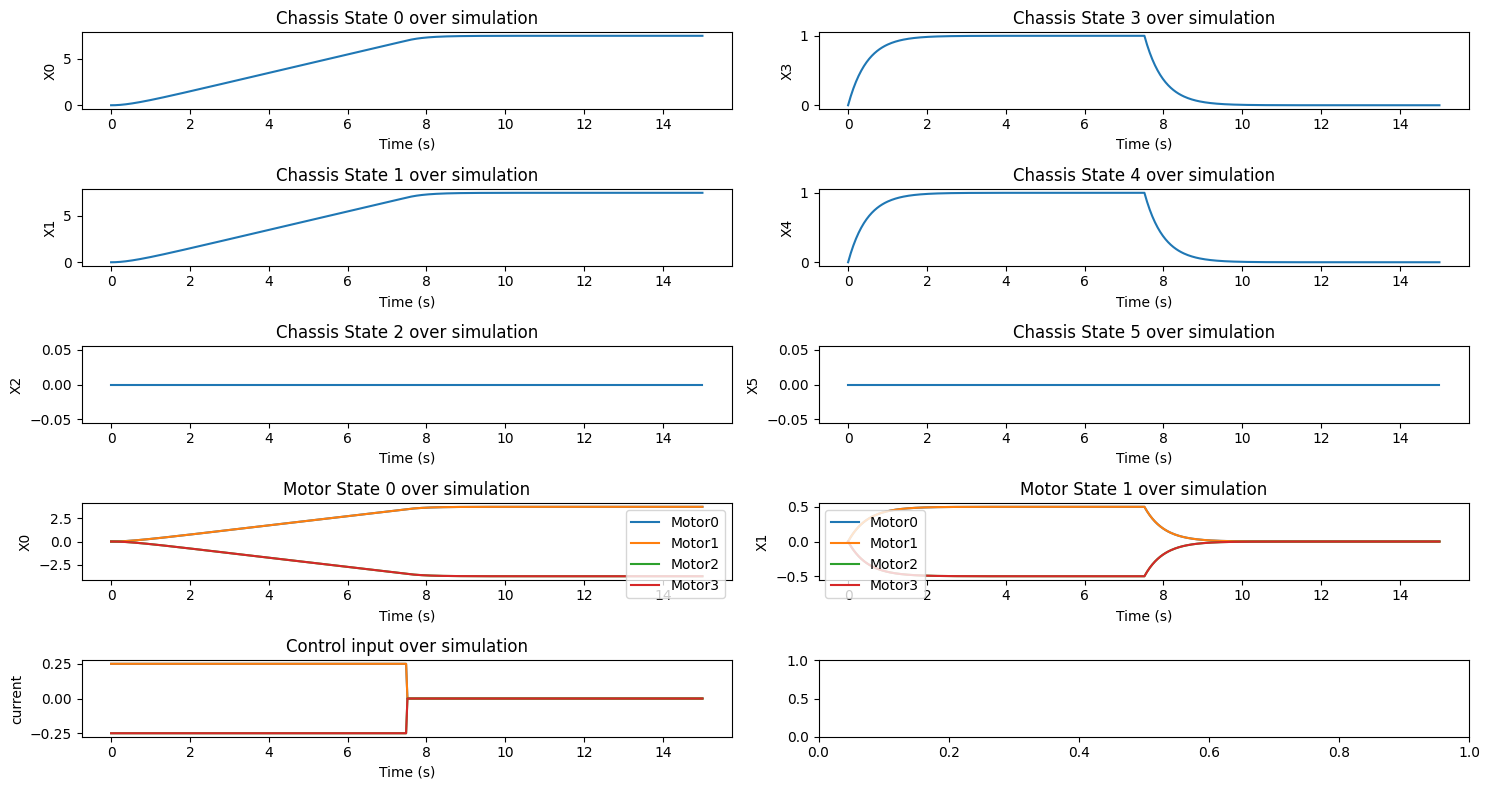

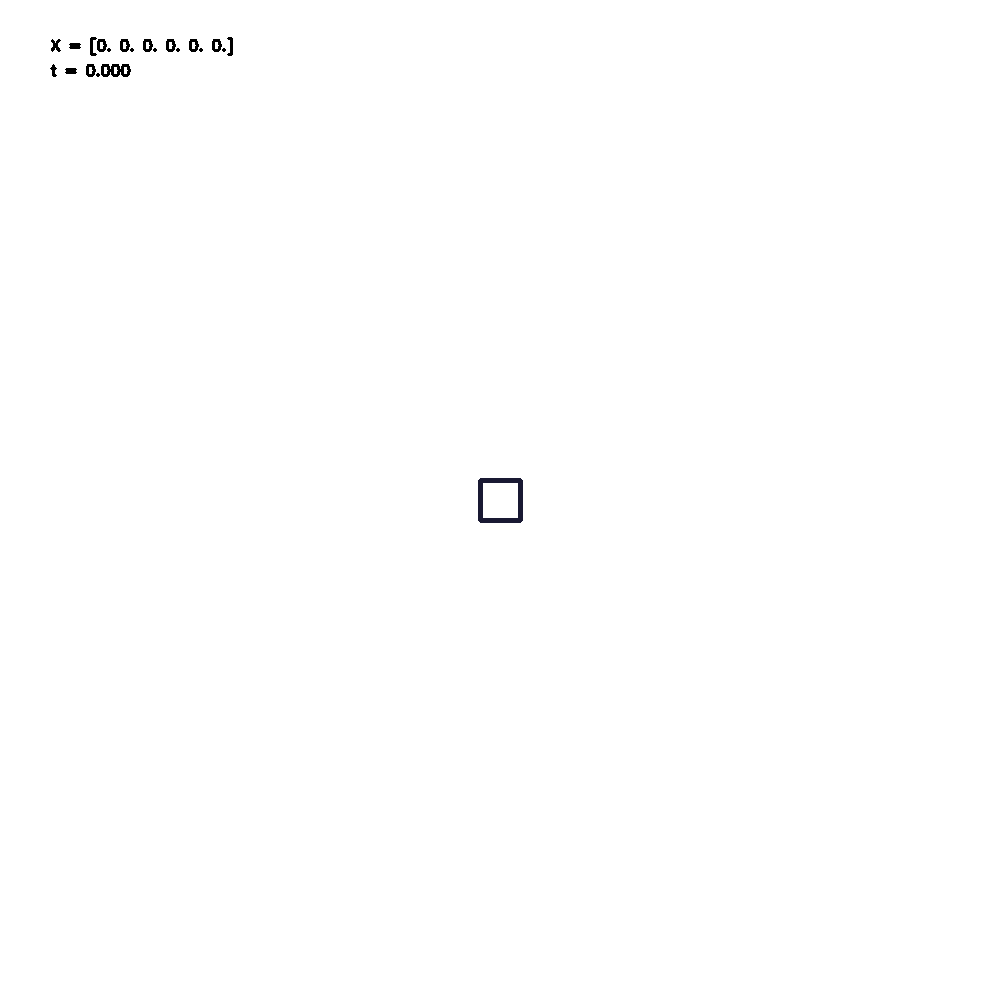

In [112]:
# Simulation run time
t_max = 15
frames = t_max * 30  # default to 30 fps
dt = t_max / frames  # Get sampling time

# bufers for history
r_hist = np.zeros((frames, N_CHASSIS_MOTORS,))
u_hist = np.zeros((frames, N_CHASSIS_MOTORS,))
x_hist = np.zeros((frames, N_CHASSIS_STATES,))
m_hist = np.zeros((frames, N_CHASSIS_MOTORS, N_MOTOR_STATES,))

# Set initial conditions like this
# x_hist[0,0] = 0.0  # X position
# x_hist[0,1] = 0.0  # Y Position
# x_hist[0,2] = Q_PI # Theta
# x_hist[0,3] = 0.0  # X speed
# x_hist[0,4] = 0.0  # Y speed
# x_hist[0,5] = 0.0  # Theta speed


print(f"Simulating {frames} frames over {t_max} seconds\n\tIC:\n{x_hist[0]}\n{m_hist[0]}\n{u_hist[0]}")

u = np.array([[0.25], 
              [0.25], 
              [-0.25], 
              [-0.25]]).reshape((N_CHASSIS_MOTORS,)) # test the sim with various constant U's


for (i, t) in enumerate(np.linspace(0, t_max, frames-1)):
#     u = np.array([[-0.25], 
#               [0.25], 
#               [0.25], 
#               [-0.25]]).reshape((N_CHASSIS_MOTORS,)) # Or try an input that changes over time
    
    # Shutdown motor input
    if t > t_max / 2:
        u *= 0

    x = x_hist[i][0]
    y = x_hist[i][1]
    
    # update states
    dx, dm = xdrive_dynamics(x_hist[i], m_hist[i], u)
    
    # write history
    u_hist[i] = u
    x_hist[i+1] = x_hist[i] + (dx * dt)
    m_hist[i+1] = m_hist[i] + (dm * dt)
    
u_hist[i+1] = u

save_path = save_sim_history(x_hist, m_hist, u_hist, t_max)
plt.show()
display.Image(save_path)

## Controller Synthesis

$\:$ CU Robotics locomotion team has designed a controller architecture that divides the system into two levels: robot level and motor level. The robot level means references and states are based on the robot frame defined above and can be interpreted in a 6DOF cartesian matter. At the motor level the controls will be SISO (Single Input Single Output) allowing us to use classical linear control methods to acheive performance requirements. Another benefit of this is how we can modify and augment motor systems individually without affecting the robot level systems (autonomous navigation and command interpretation).

$\:$ I was asked not to disclose how the team actually handles input from autonomy and human drivers. So here we will design a controller that computes a velocity using a simple control law; $V = K_p*(r-x)$. This is a proportional control law that will output a velocity based on an error in the robots position. Combining this velocity with our inverse kinematics will produce a target state for each motor. Now the goal is to design a motor controller that can track the state (a fairly basic control task). This simplifies our controller from a heavily cross coupled and multivariable system to a set of simple systems with well defined soutions. 

### 1) Compute each motor's reference from the robot control input

Given a robot velocity vector $u_{rc}$ in robot frame, we can determine the required speed of each motor.

$$r_{m} = G_{ik}u_{rc}$$

### 2) Track the motor references using full state feedback

Now the only control synthesis needed is for making motors track their given speeds. We implement this controller as a vector of gains ($K$) multiplied by the error state of the motor ($(r_{mi} - x_{m})). This is known as full state feedback control. Given the sensors on each motor the states are available at a rate of 1kHz. This is also the rate we will run our controls at.

$$u_{mi} = K(r_{mi} - x_{m})$$

$$u_{mi} = K_i(
\begin{bmatrix}
    \int r_{mi}dt \\
    r_{mi}
\end{bmatrix}- 
\begin{bmatrix}
    \theta \\
    \dot{\theta}
\end{bmatrix})$$

> $u_{mi}$ is the control value sent to each motor \
> $r_{mi}$ is the motor reference speed of the i'th motor \
> $u_{rc}$ is the remote control input (robot state velocities) \
> $G_{ik}$ is a linear transform that relates the two (inverse kinematics of the robot) \
> $K_i$ is a gain vector for the the i'th motor \
> In practice a motor's state could have more terms but in terms of gain synthesis problem setup we will only use the two

> A large benefit to this control structure is how easily we can adjust each motor's model and gains to better fit it's purpose while not changing anything at the robot level. A good example is the pitch control. The pitch will need to have a third state to allow for gravity compensation. This is because we can't relate the motor's position to the robots state only the velocities. Relating the states would require a calibration routine or an encoder on the pitch axle.


## Synthesis problem

$\:$ To implement this controller we will need to find $G_k$ and $K_i$. These matrices are our controller knobs, by adjusting the values in these matrices we can tune the behavior of our controller to meet performance requirements. The next part of the synthesis process will involve designing a process to calculate these matrices. This process will provide us with a set of sythesizer knobs that provide an initial guess for the controller knobs. It follows that understanding how to tune the synthesizer knobs requires understanding the controller knobs.


### Finding $G_{ik}$
$\:$ With some intuition $G_{k}$ can be extracted from $B_{k}$ such that
$$G_{ik}^{-1}=G_{k}=
\begin{bmatrix}
    1 & 0 & -1 & 0 \\ 
    0 & 1 & 0 & -1 \\
    1 & 1 & 1 & 1  
\end{bmatrix}$$

This implies 
$$\begin{bmatrix}
    1 & 0 & -1 & 0 \\ 
    0 & 1 & 0 & -1 \\
    1 & 1 & 1 & 1  
\end{bmatrix}
r_{m} = \hat{x}_v$$

where $\hat{x}_v$ is an estimate of our robots velocity state (x3:x5), this is an example of using the forward kinematics.

$$x = 
\begin{bmatrix}
    x_p \\
    x_v
\end{bmatrix}$$

$\:$ Finding the inverse is a bit tricky because it is a non-square singular matrix (it does not have an inverse). To handle this we use the least squares equation to find a psuedo-inverse. The psuedo-inverse is the closest possible matrix to what would be the inverse if one existed.

$$G_{ik}=G_{k}^T(G_{k}G_{k}^T)^{-1}$$

$$G_{ik}=
\begin{pmatrix}
    \begin{bmatrix}
        1 & 0 & -1 & 0 \\ 
        0 & 1 & 0 & -1 \\
        1 & 1 & 1 & 1  
    \end{bmatrix}\begin{bmatrix}
        1 & 0 & -1 & 0 \\ 
        0 & 1 & 0 & -1 \\
        1 & 1 & 1 & 1  
    \end{bmatrix}^T
\end{pmatrix}^{-1}
\begin{bmatrix}
    1 & 0 & -1 & 0 \\ 
    0 & 1 & 0 & -1 \\
    1 & 1 & 1 & 1  
\end{bmatrix}$$

$$G_{ik}=
\begin{bmatrix}
    0 & \frac{1}{2} & \frac{1}{4} \\ 
    \frac{1}{2} & 0 & \frac{1}{4} \\
    0 & -\frac{1}{2} & \frac{1}{4} \\
    -\frac{1}{2} & 0 & \frac{1}{4}  
\end{bmatrix}$$

In [113]:
Gk = B_chassis[3:]
Gk.T @ la.inv(Gk @ Gk.T) # Least Squares Equation to Solve Ax = b for x

array([[ 0.  ,  0.5 ,  0.25],
       [ 0.5 ,  0.  ,  0.25],
       [ 0.  , -0.5 ,  0.25],
       [-0.5 ,  0.  ,  0.25]])

> If you want to change your robots kinematics, edit the B matrix to match your chassis and rerun the above command

> Most systems will have a relationship like this that relates its actuator inputs to its states.

A system is deemed controlable when the rank (number of eigen values) of

$$\begin{bmatrix}
    B & AB & A^2B & ... & A^nB
\end{bmatrix}$$

is greater than n, the number of states. This means that through all the available actuator inputs we can control all the states.

>**Challange: Is the system controlable if we remove motors 2 and 4?**

### Finding $K_i$

$\:$There are many techniques and tools for finding a good $K$, there is no best $K$ because they all have different advantages (though some are definitely worse). This year the team wants to use LQR control to provide the initial controller knob guess. The synthesizer knobs are $Q$ and $R$: state cost and actuation cost respectively. LQR will find the gains that minimize the cost equation

$$J=\int x^TQx+u^TRu\,dt$$

In [114]:
# Dark magic (Algebraic Riccati Equation)
def lqr(A, B, Q, R):
    print(f"A:\n{A}\nB:\n{B}")
    P = la.solve_discrete_are(A, B, Q, R)
    return P, la.solve(R + B.T.dot(P).dot(B), B.T.dot(P).dot(A)).flatten()

Q = np.array([[1.0,  0.0], 
              [0.0, 0.5]]) # use nominal error / nominal output for each state (nominal output = 1)
R = np.array([0.00000]) # no cost on actuation, cause why not it's a sim

sample_time = 1e-3
A_motor_disc = np.eye(A_motor.shape[0], A_motor.shape[1]) + (A_motor * sample_time) # x(t) = (I + At)x(t) sampling time = 1ms
B_motor_disc = B_motor.reshape((2,1)) * sample_time
P, K = lqr(A_motor_disc, B_motor_disc, Q, R)
print(f"found gains [{K[0]:.4f}, {K[1]:.4f}]")

A:
[[1.    0.001]
 [0.    0.998]]
B:
[[0.   ]
 [0.004]]
found gains [353.3035, 249.8533]


### Validate K

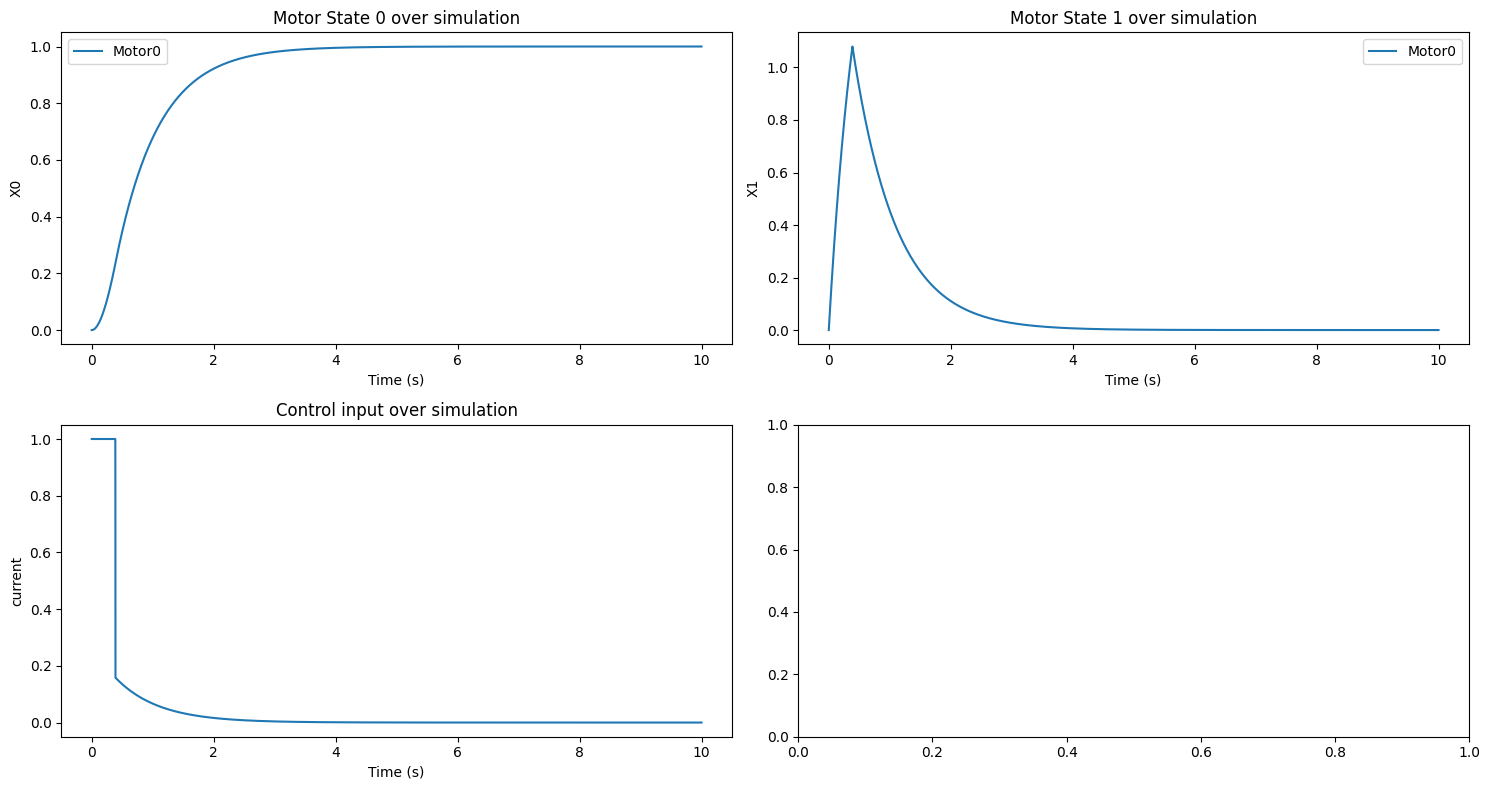

In [115]:
# Simulation run time
t_max = 10
frames = t_max * 1000
dt = t_max / frames

# Initial conditions
m0 = np.zeros((1, N_MOTOR_STATES,))

# bufers for history
m_hist = np.zeros((frames, 1, N_MOTOR_STATES,))
u_hist = np.zeros((frames, 1,))

r = np.array([[1,0] for _ in range(frames-1)])

for (i, t) in enumerate(np.linspace(0, t_max, frames-1)):
    # update states
    u = np.array([min(max(K @ (r[i] - m_hist[i,0]), -1), 1)])
    _, dm = motor_dynamics(m_hist[i], u)
    # write history
    m_hist[i+1] = m_hist[i] + (dm * dt)
    u_hist[i] = u
    
fig, axes = plt.subplots(2, 2, figsize=(15,8))
plot_motor_history(fig, axes, m_hist, t_max)
plot_control_history(fig, axes, u_hist, t_max, fig_offset=1)
plt.tight_layout()
plt.show()

# System Identification

$\:$ We have created a few controller knobs that influence our motor controllers and a few knobs that influence how we synthesis our motor controllers. The algorithm is fancy and fun to learn about but the gains found certainly will not work on the robot. The problem is our model might be similar, but it is not as close as we need it to be. Now the goal is to achieve nearly identical results in simulation as on hardware (for more complicated systems this can be very difficult).

We have defined a state space model for a motor with generic parameters. This model can be rearranged to fit a in a least squares equation.

$$\dot{x}=Ax+Bu\rightarrow\dot{x}=\bar{A}\bar{x}=
\begin{bmatrix}
    A \\
    B
\end{bmatrix}
\begin{bmatrix}
    x \\
    u
\end{bmatrix}$$

Apply the least squares formula

$$
\begin{bmatrix}
    A \\
    B
\end{bmatrix} = 
(\begin{bmatrix}
    x \\
    u
\end{bmatrix}^T
\begin{bmatrix}
    x \\
    u
\end{bmatrix})^{-1}
\begin{bmatrix}
    x \\
    u
\end{bmatrix}^T\dot{x}$$

Then confirm the model via

    x_current = x(0)
    x_hist = []
    for i in sim_time:
        x_current += Ax_current + Bu(i)
        x_hist.append(x_current)

    ASSERT(sum((x - x_current)^2) < threshold)

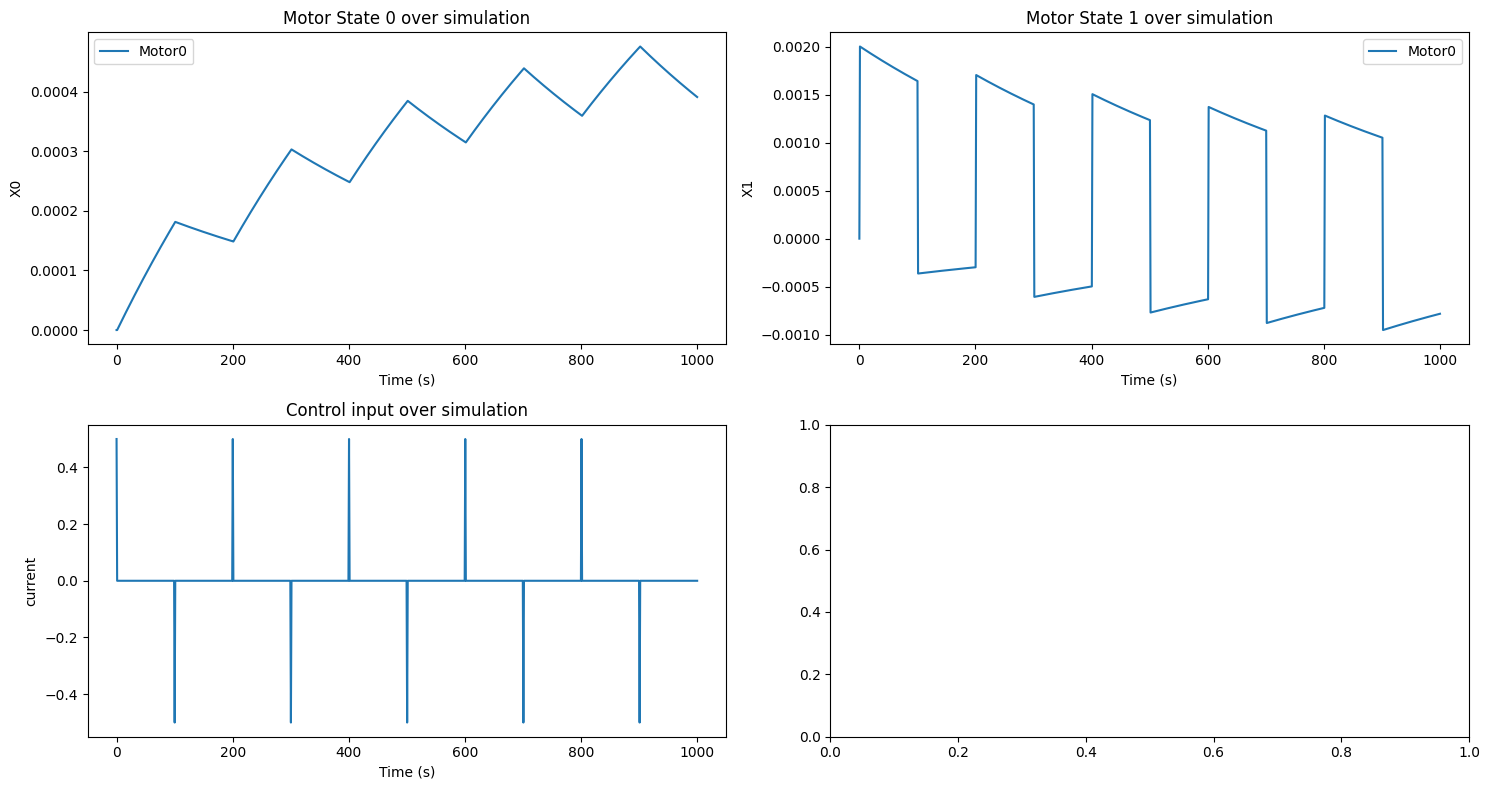

Solving (2, 3) @ (3, 999) = (2, 999)
Found (2, 3)
[[ 1.     0.001 -0.   ]
 [ 0.     0.998  0.004]]
Modeled system: (A(2, 2) B(2, 1))
A:
[[1.    0.001]
 [0.    0.998]]
B
[[-0.   ]
 [ 0.004]]
Difference from original model:
A:
[[0. 0.]
 [0. 0.]]
B
[[0.]
 [0.]]


In [116]:
# bufers for history
t_max = 1000
frames = 1000
m_hist = np.zeros((frames, 1, N_MOTOR_STATES,))
u_hist = np.zeros((frames, 1,))

sign = 1
r = np.array([[1,0] for _ in range(frames-1)])
for (i, t) in enumerate(np.linspace(0, t_max, frames-1)):
    # update states
    if i % 100 == 0:
        u = sign * np.array([0.5])
        sign *= -1
    else:
        u *= 0
    
    _, dm = motor_dynamics(m_hist[i], u)
    # write history
    m_hist[i+1] = m_hist[i] + (dm * dt)
    u_hist[i] = u
    
fig, axes = plt.subplots(2, 2, figsize=(15,8))
plot_motor_history(fig, axes, m_hist, t_max)
plot_control_history(fig, axes, u_hist, t_max, fig_offset=1)
plt.tight_layout()
plt.show()
    
samples = len(m_hist)
if samples != 0:
    A = np.vstack([m_hist[:-1, 0, 0], m_hist[:-1, 0, 1], u_hist[:-1,0]])
    B = np.vstack([m_hist[1:, 0, 0], m_hist[1:, 0, 1]])

    print(f"Solving {(B.shape[0], A.shape[0])} @ {A.shape} = {B.shape}")
    # Least Squares finds a psuedo inverse, this particular 
    # implementation actually uses singular value decomposition (SVD)
    # Which tends to work better.
    X = B @ la.pinv(A) 

    print(f"Found {X.shape}\n{np.round(X, 4)}")

    sys_A = X[:,:-1]
    sys_B = np.array([X[:,-1]]).T

    print(f"Modeled system: (A{sys_A.shape} B{sys_B.shape})\nA:\n{np.round(sys_A,4)}\nB\n{np.round(sys_B,4)}")
    print(f"Difference from original model:")
    print(f"A:\n{np.round(abs(A_motor_disc - sys_A),4)}")
    print(f"B\n{np.round(abs(B_motor_disc - sys_B),4)}")

## Controller Simulation

In [117]:
Gk = B_chassis[3:-1]
Gik = Gk.T @ la.inv(Gk @ Gk.T) 

A:
[[1.    0.001]
 [0.    0.998]]
B:
[[0.   ]
 [0.004]]
found gains [0.7067, 0.3084]
Simulating 500 frames over 10 seconds
	IC:
[ 10.         -10.           1.57079633   0.           0.
   0.        ]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[0. 0. 0. 0.]


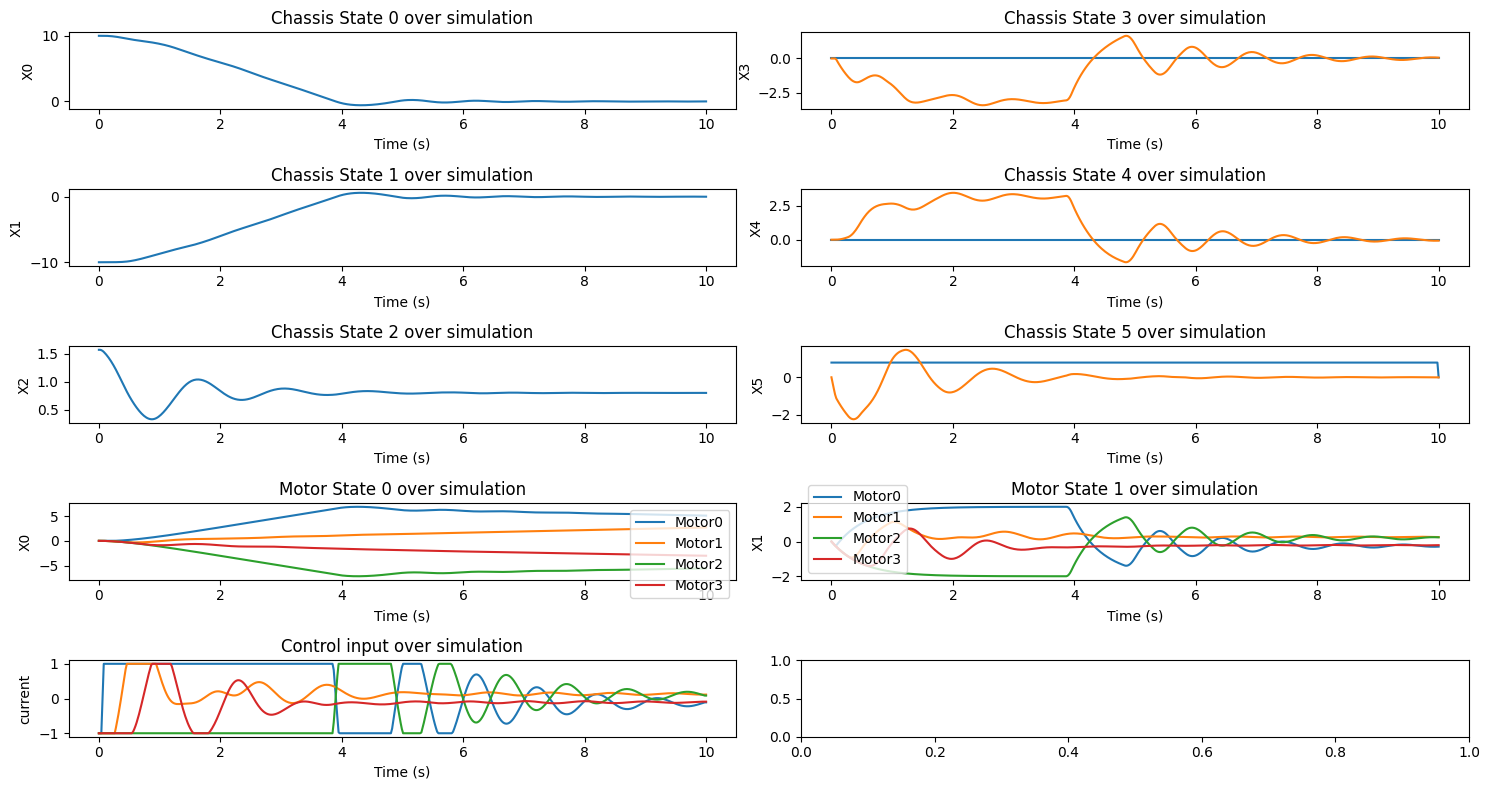

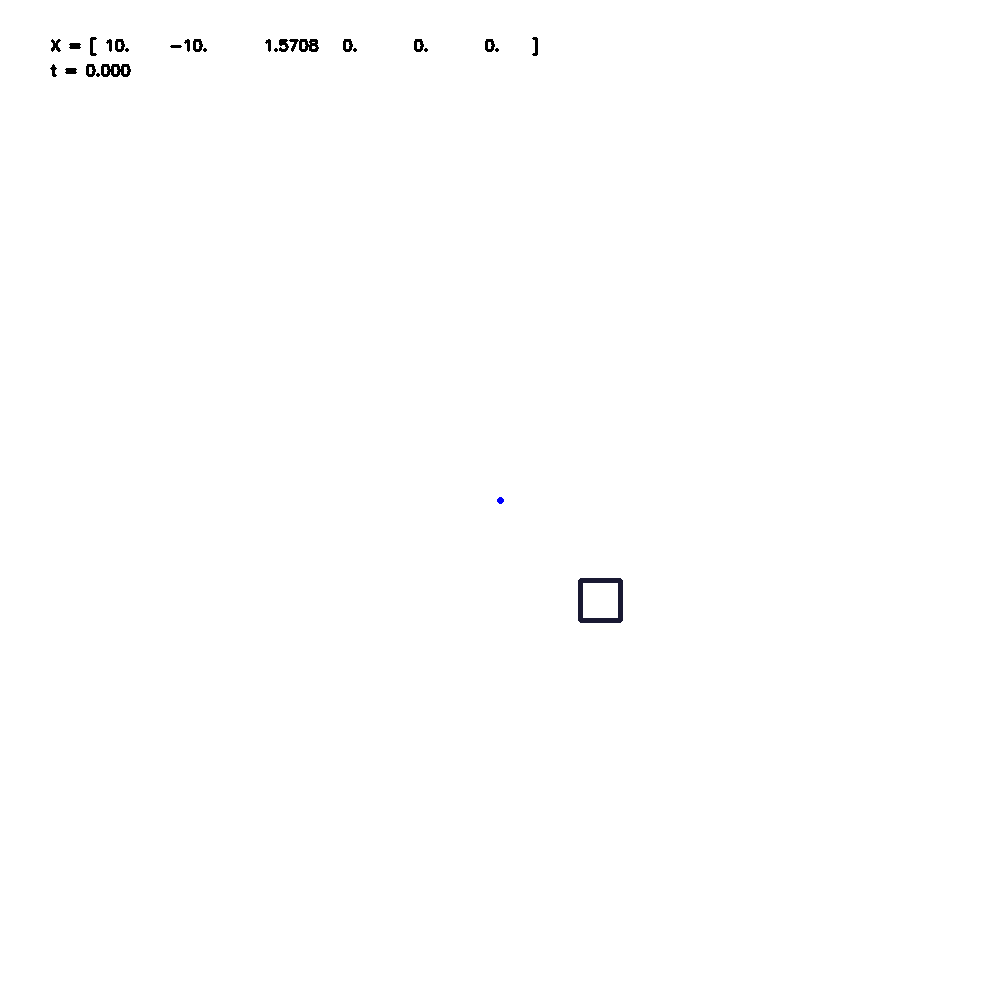

In [119]:
# Simulation run time
t_max = 10
frames = 500
dt = t_max / frames

# Rerun the inverse kinematics just because it's cool
Gk = B_chassis[3:]
Gik = Gk.T @ la.inv(Gk @ Gk.T) 

# Syntheziser knobs (best to keep Q diagonal)
Q = np.array([[1.0, 0.0], 
              [0.0, 0.1]]) # use nominal error / nominal output for each state (nominal output = 1)
R = np.array([2.0]) # no cost on actuation, cause why not it's a sim

sample_time = 1e-3
A_motor_disc = np.eye(A_motor.shape[0], A_motor.shape[1]) + (A_motor * sample_time) # x(t) = (I + At)x(t) sampling time = 1ms
B_motor_disc = B_motor.reshape((2,1)) * sample_time

P, K = lqr(A_motor_disc, B_motor_disc, Q, R)
print(f"found gains [{K[0]:.4f}, {K[1]:.4f}]")

# make a dummy position error gain
# this controls how position error
# relates to speed
Kp = 10
    
# make a dummy robot positon state
r = np.array([[0.0], # might be a bug somewhere this stuff is weird
              [0.0], 
              [Q_PI]]).reshape((int(N_CHASSIS_STATES/2),))

# bufers for history
r_hist = np.zeros((frames, int(N_CHASSIS_STATES/2),))
u_hist = np.zeros((frames, N_CHASSIS_MOTORS,))
x_hist = np.zeros((frames, N_CHASSIS_STATES,))
m_hist = np.zeros((frames, N_CHASSIS_MOTORS, N_MOTOR_STATES,))

# Set initial conditions like this
x_hist[0,0] = 10.0  # X position
x_hist[0,1] = -10.0  # Y Position
x_hist[0,2] = HALF_PI # Theta
x_hist[0,3] = 0.0  # X speed
x_hist[0,4] = 0.0  # Y speed
x_hist[0,5] = 0.0  # Theta speed

print(f"Simulating {frames} frames over {t_max} seconds\n\tIC:\n{x_hist[0]}\n{m_hist[0]}\n{u_hist[0]}")

for (i, t) in enumerate(np.linspace(0, t_max, frames-1)):

    x = x_hist[i,0]
    y = x_hist[i,1]
    theta = x_hist[i,2]
    
    # find the motor references based on position error (need to put in robot frame)
    c = np.cos(theta)
    s = np.cos(theta)
    R = np.array([[ c, s, 0],
                  [-s, c, 0],
                  [ 0, 0, 1]]).reshape(3,3)
    position_error = R @ (r - x_hist[i,:3])
    mr = Gik @ (Kp * position_error)
    
    # find the motor output values based on the motor references
    u = np.array([min(max(K @ (m - m_hist[i,0]), -1), 1) for (i,m) in enumerate(mr)])
    
    # update states
    dx, dm = xdrive_dynamics(x_hist[i], m_hist[i], u) # control needs to be in robot frame
    
    # write history
    u_hist[i] = u
    r_hist[i] = r
    x_hist[i+1] = x_hist[i] + (dx * dt)
    m_hist[i+1] = m_hist[i] + (dm * dt)
    
u_hist[i+1] = u

save_path = save_sim_history(x_hist, m_hist, u_hist, t_max, R=r_hist)
plt.show()
display.Image(save_path)